# Basic cartoframes usage

`cartoframes` lets you use CARTO in a Python environment so that you can do all of your analysis and mapping in, for example, a Jupyter notebook. `cartoframes` allows you to use CARTO's functionality for data analysis, storage, location services like routing and geocoding, and visualization.

You can view this notebook best on `nbviewer` here: <https://nbviewer.jupyter.org/github/CartoDB/cartoframes/blob/master/examples/Basic%20Usage.ipynb>
It is recommended to download this notebook and use on your computer instead so you can more easily explore the functionality of `cartoframes`.

To get started, let's load the required packages, and set credentials.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartoframes
from cartoframes import Credentials
import pandas as pd

USERNAME = 'eschbacher'  # <-- replace with your username 
APIKEY = 'abcdefg'       # <-- your CARTO API key
creds = Credentials(username=USERNAME, 
                    key=APIKEY)
cc = cartoframes.CartoContext(creds=creds)

## `cc.read`

`CartoContext` has several methods for interacting with [CARTO](https://carto.com) in a Python environment. `CartoContext.read` allows you to pull a dataset stored on CARTO into a [pandas](http://pandas.pydata.org/) DataFrame. In the cell below, we use `cc.read` to get the table `brooklyn_poverty` from a CARTO account. You can get a CSV of the table here for uploading to your CARTO account:

<https://cartoframes.carto.com/api/v2/sql?q=SELECT+*+FROM+brooklyn_poverty&format=csv&filename=brooklyn_poverty>

In [2]:
# Get a CARTO table as a pandas DataFrame
df = cc.read('brooklyn_poverty')
df.head()

,geoid,pop_determined_poverty_status_2011_2015,poverty_count,poverty_per_pop,the_geom,total_pop_2011_2015,total_population,walked_to_work_2011_2015
cartodb_id,,,,,,,,
2052,360479901000,NaN,NaN,NaN,None,NaN,0,NaN
111,360470666001,0.000584,NaN,NaN,0106000020E6100000030000000103000000010000006B...,0.000739,0,1.553393e-12
1606,360470702031,0.000000,NaN,NaN,0106000020E61000000800000001030000000100000013...,0.000000,0,NaN
116,360470702030,NaN,NaN,NaN,None,NaN,0,NaN
278,360470078001,39510.687345,487.962222,0.28436,0106000020E61000000100000001030000000100000007...,60285.457763,1716,1.389958e-02


Notice that:

* the index of the DataFrame is the same as the index of the CARTO table (`cartodb_id`)
* `the_geom` column stores the geometry. This can be decoded if we set the `decode_geom=True` flag in `cc.read`, which requires the library `shapely`.
* We have several numeric columns
* SQL `null` values are represented as `np.nan`

Other things to notice:

In [3]:
df.dtypes

geoid                                       object
pop_determined_poverty_status_2011_2015    float64
poverty_count                              float64
poverty_per_pop                            float64
the_geom                                    object
total_pop_2011_2015                        float64
total_population                             int64
walked_to_work_2011_2015                   float64
dtype: object

The `dtype` of each column is a mapping of the column type on CARTO. For example, `numeric` will map to `float64`, `text` will map to `object` (pandas string representation), `timestamp` will map to `datetime64[ns]`, etc. The reverse happens if a DataFrame is sent to CARTO.

## `cc.map`

Now that we can inspect the data, we can map it to see how the values change over the geography. We can use the `cc.map` method for this purpose.

`cc.map` takes a `layers` argument which specifies the data layers that are to be visualized. They can be imported from `cartoframes` as below.

There are different types of layers:

* `Layer` for visualizing CARTO tables
* `QueryLayer` for visualizing arbitrary queries from tables in user's CARTO account
* `BaseMap` for specifying the base map to be used

Each of the layers has different styling options. `Layer` and `QueryLayer` take the same styling arguments, and `BaseMap` can be specified to be light/dark and options on label placement.

Maps can be `interactive` or not. Set interactivity with the `interactive` with `True` or `False`. If the map is static (not interactive), it will be embedded in the notebook as either a `matplotlib` axis or `IPython.Image`. Either way, the image will be transported with the notebook. Interactive maps will be embedded zoom and pan-able maps.

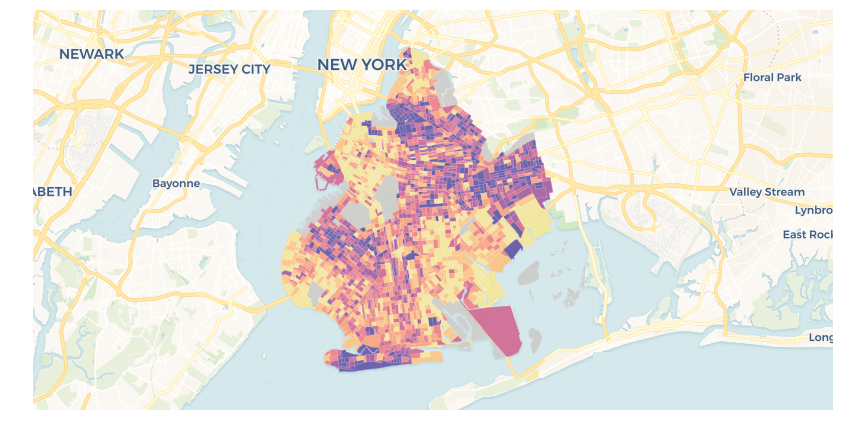

In [4]:
from cartoframes import Layer, styling, BaseMap
l = Layer('brooklyn_poverty',
          color={'column': 'poverty_per_pop',
                 'scheme': styling.sunset(7)})
cc.map(layers=l,
       interactive=False)

### Multiple variables together

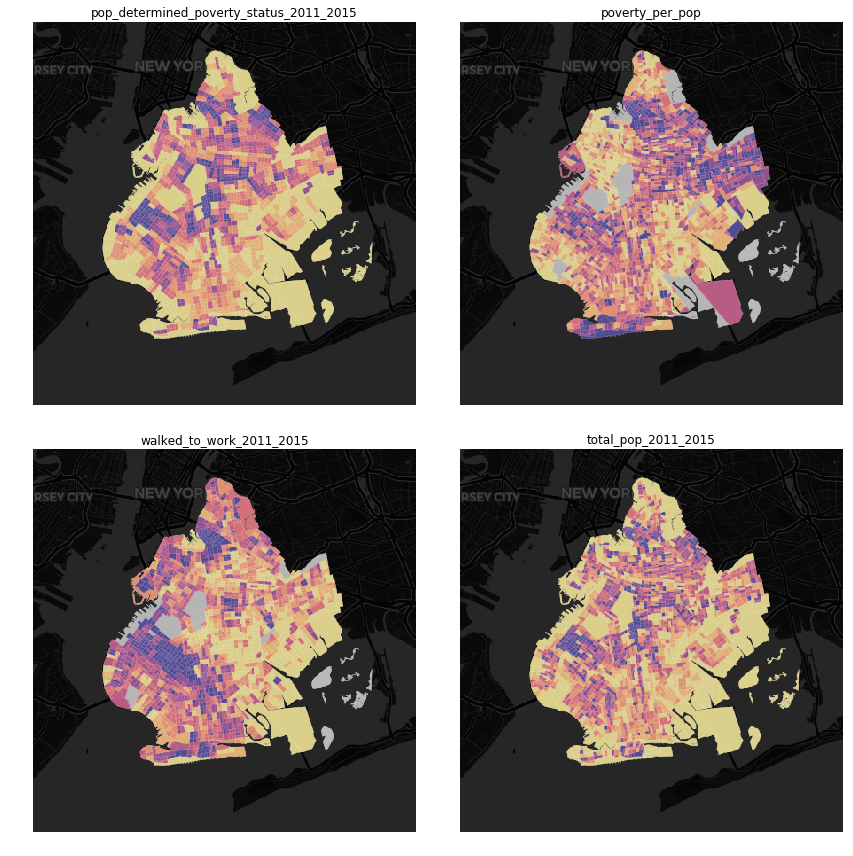

In [5]:
table = 'brooklyn_poverty'
cols = [
    'pop_determined_poverty_status_2011_2015',
    'poverty_per_pop',
    'walked_to_work_2011_2015',
    'total_pop_2011_2015'
]

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

for idx, col in enumerate(cols):
    cc.map(layers=[BaseMap('dark'), Layer(table,
                        color={'column': col,
                               'scheme': styling.sunset(7, 'quantiles')})],
           ax=axs[idx // 2][idx % 2],
           zoom=11, lng=-73.9476, lat=40.6437,
           interactive=False,
           size=(432, 432))
    axs[idx // 2][idx % 2].set_title(col)
fig.tight_layout()
plt.show()

## NYC Taxi Dataset

Let's explore a typical `cartoframes` workflow using data on NYC taxis.

To get the data into CARTO, we can:
1. Use `pandas` to grab the data from the cartoframes example account
2. Send it to your CARTO account using `cc.write`, specifying the `lng`/`lat` columns you want to use for visualization
3. Set `overwrite=True` to replace an existing dataset if it exists
4. Refresh our `df` with the CARTO-fied version using `cc.read``

In [6]:
# read in a CSV of NYC taxi data from cartoframes example datasets
df = pd.read_csv('https://cartoframes.carto.com/api/v2/sql?q=SELECT+*+FROM+taxi_50k&format=csv')

# set the index of the dataframe to be the cartodb_id (database index)
df.set_index('cartodb_id', inplace=True)

# show first five rows to see what we've got
df.head()

,the_geom,store_and_fwd_flag,the_geom_webmercator,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,...,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
cartodb_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,False,NaN,2,2016-05-01 14:52:11+00,2016-05-01 15:00:36+00,2,2.08,-74.006706,40.730461,...,-74.012383,40.706779,1,8.5,0.0,0.5,1.00,0.0,0.3,10.30
2,NaN,False,NaN,1,2016-05-01 08:34:08+00,2016-05-01 08:49:02+00,1,3.00,-73.924957,40.744125,...,-73.973824,40.762779,1,13.5,0.0,0.5,2.00,0.0,0.3,16.30
3,NaN,False,NaN,1,2016-05-04 09:44:40+00,2016-05-04 10:07:09+00,1,2.10,-73.973488,40.748501,...,-73.998955,40.740833,2,14.5,0.0,0.5,0.00,0.0,0.3,15.30
4,NaN,False,NaN,2,2016-05-01 20:50:11+00,2016-05-01 21:05:24+00,1,4.41,-73.999786,40.743267,...,-73.966362,40.792370,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30
5,NaN,False,NaN,2,2016-05-02 07:26:56+00,2016-05-02 07:53:53+00,2,4.01,-73.963631,40.803360,...,-73.956963,40.784939,1,19.5,0.0,0.5,4.06,0.0,0.3,24.36


In [7]:
# send it to carto so we can map it
# specify the columns we want to have as a point (pickup location)
cc.write(df, 'taxi_50k',
         lnglat=('pickup_longitude', 'pickup_latitude'),
         overwrite=True)

# read the fresh carto-fied version
df = cc.read('taxi_50k')

/Users/aeschbacher/.local/share/virtualenvs/cartoframes-pRWzcuWT/lib/python3.6/site-packages/carto/resources.py:90: FutureWarning: This is part of a non-public CARTO API and may change in the future. Take this into account if you are using this in a production environment
  warnings.warn('This is part of a non-public CARTO API and may change in the future. Take this into account if you are using this in a production environment', FutureWarning)


Table successfully written to CARTO: https://eschbacher.carto.com/dataset/taxi_50k
`the_geom` column is being populated from `('pickup_longitude', 'pickup_latitude')`. Check the status of the operation with:
    BatchJobStatus(CartoContext(), '2c9704c6-bf92-4d0e-9691-a06185f33d61').status()
or try reading the table from CARTO in a couple of minutes.
Note: `CartoContext.map` will not work on this table until its geometries are created.


Take a look at the data on a map.

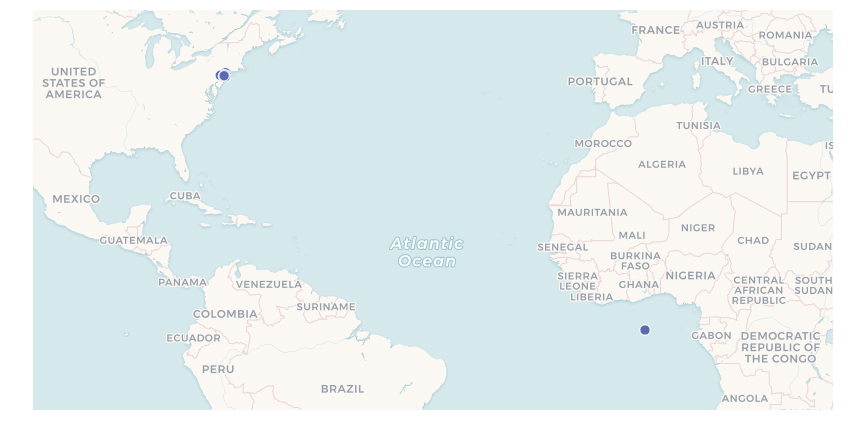

In [9]:
from cartoframes import Layer
cc.map(layers=Layer('taxi_50k'),
       interactive=False)

Oops, there are some zero-valued long/lats in there, so the results are going to [null island](https://en.wikipedia.org/wiki/Null_Island). Let's remove them.

In [10]:
# select only the rows which are not at (0,0)
df = df[(df['pickup_longitude'] != 0) | (df['pickup_latitude'] != 0)]
# send back up to CARTO
cc.write(df, 'taxi_50k', overwrite=True,
         lnglat=('pickup_longitude', 'pickup_latitude'))

/Users/aeschbacher/.local/share/virtualenvs/cartoframes-pRWzcuWT/lib/python3.6/site-packages/carto/resources.py:90: FutureWarning: This is part of a non-public CARTO API and may change in the future. Take this into account if you are using this in a production environment
  warnings.warn('This is part of a non-public CARTO API and may change in the future. Take this into account if you are using this in a production environment', FutureWarning)


Table successfully written to CARTO: https://eschbacher.carto.com/dataset/taxi_50k
`the_geom` column is being populated from `('pickup_longitude', 'pickup_latitude')`. Check the status of the operation with:
    BatchJobStatus(CartoContext(), '4e43f0f5-47a0-4911-a0e4-d9c6f418c8ef').status()
or try reading the table from CARTO in a couple of minutes.
Note: `CartoContext.map` will not work on this table until its geometries are created.


BatchJobStatus(job_id='4e43f0f5-47a0-4911-a0e4-d9c6f418c8ef', last_status='pending', created_at='2018-04-18T13:01:38.189Z')

Instead of using pandas, we could remove those rows on the database by using SQL.

```python
cc.query('''
DELETE FROM taxi_50k
WHERE pickup_longitude = 0 and pickup_latitude = 0
''')
```

In [11]:
# Let's take a look at what's going on, styled by the fare amount
cc.map(layers=Layer('taxi_sample',
                    size=4,
                    color={'column': 'fare_amount',
                           'scheme': styling.sunset(7)}),
       interactive=True)

We can use the `zoom=..., lng=..., lat=...` information in the embedded interactive map to help us get static snapshots of the regions we're interested in. For example, JFK airport is around `zoom=12, lng=-73.7880, lat=40.6629`. We can paste that information as arguments in `cc.map` to generate a static snapshot of the data there.

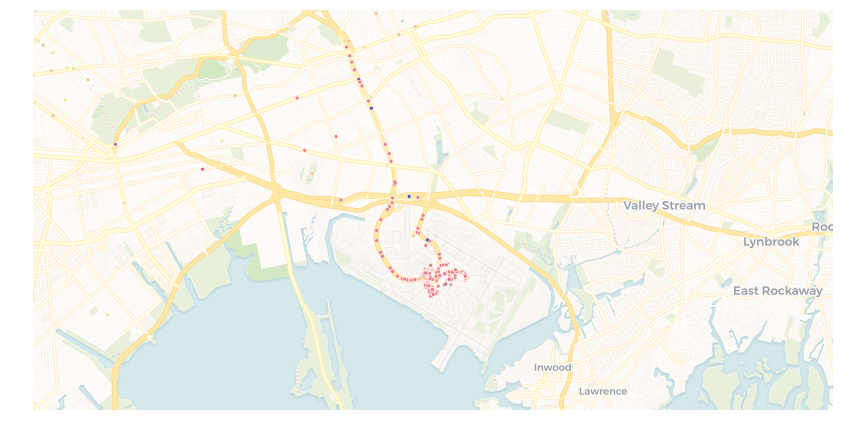

In [12]:
# Let's take a look at what's going on at JFK airport, styled by the fare amount, and STATIC
cc.map(layers=Layer('taxi_sample',
                    size=4,
                    color={'column': 'fare_amount',
                           'scheme': styling.sunset(7)}),
       zoom=12, lng=-73.7880, lat=40.6629,
       interactive=False)